#### **Author:** Quilee Simeon (qsimeon@mit.edu)

In [9]:
# @title Imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binomtest
from collections import defaultdict
from matplotlib.ticker import MaxNLocator

#### **Overview of Lempel-Ziv Complexity**

The Lempel-Ziv complexity of a sequence measures how many different "phrases" or patterns you encounter as you read through the sequence from start to finish. Each time you encounter a new pattern that hasn't been seen before in the sequence, the complexity count increases. This measure gives us an idea of the randomness or the structure within the sequence.

#### **Terms Used in the Algorithm**

- **Sequence (S)**: The data string or list you're analyzing. It can consist of any symbols from a finite alphabet (like letters or numbers), not just binary data.
- **Pointer (p)**: This refers to a specific location within the sequence where you are currently trying to match a pattern.
- **Component (v)**: This is the current substring or pattern length being checked for repetitions within the sequence.
- **Prefix (u)**: This is the position up to which all characters have been processed in forming complete patterns.
- **vmax**: This holds the maximum length of the pattern found while checking different positions. It is used to determine the length of the next pattern to be processed.
- **Complexity (C)**: This is a count of how many unique patterns or components have been identified in the sequence.

#### **Explanation of the Algorithm**

Imagine you have a sequence like "ABABABC". The goal is to see how many unique patterns or phrases you can form without repeating previous patterns:

1. **Initialize**: Start with `i = 0`, which means you begin checking from the first character. The complexity `C` starts at 1 because you always have at least one unique component in any non-empty sequence. Set `u = 1`, indicating you start checking from the first position, and `v = 1` for the initial length of the pattern.

2. **Loop through the Sequence**:
   - **Check for Match**: Compare the character at position `i + v` with `u + v`. If they match, it means the current component can be extended, so increase `v` by 1.
   - **No Match or End of Component**: If they don't match or you've finished comparing:
     - Update `vmax` to be the larger of `v` or the existing `vmax`, which tracks the longest component found so far.
     - Increment `i` by 1 to check starting from the next position.
     - If `i` equals `u` (meaning you've checked all possible starting positions for this component length), it's time to finalize this component:
       - Increase the complexity `C` by 1 because you've identified a unique pattern.
       - Move `u` ahead by `vmax` to start processing the next component.
       - Reset `v`, `i`, and `vmax` to start fresh for the new component.
     - If `i` is not equal to `u`, just reset `v` to 1 to try finding a component starting from the next position.

3. **End of Sequence**:
   - If you finish the loop and `v` is not 1, it means there was an ongoing component that was unique but didn't trigger an increase in `C` because the loop ended. Increase `C` by 1 to account for this last unique pattern.

This algorithm effectively allows you to measure how complex a sequence is in terms of new, non-repeating patterns, and it does so efficiently in linear time, meaning it only needs to pass through the sequence a fixed number of times proportional to the length of the sequence.


#### Lempel-Ziv complexity for the Simons game

The Lempel–Ziv complexity is the number of **different sub-strings (or sub-words) encountered as a sequence is viewed as a stream (from left to right)**.

<u>N.B.</u> Could **this** be an operational definition of what a *chunk* is? i.e. a chunk is one such sub-string/word.

Sequences with a certain regularity do not have a too large complexity, and the complexity grows as the sequence grows in length and irregularity.

The core algorithm, which involves searching for unique substrings and updating indices accordingly, remains the same regardless of the alphabet size of the sequence. For sequences derived from an alphabet larger than binary, you simply ensure that the sequence you input into the function is in a form where each symbol (a.k.a character) is distinct and treated as such by the algorithm. No conversion to a binary format is necessary, as the algorithm does not rely on the nature of the symbols/characters but rather on the structure and repetition of patterns.

In [10]:
def lempel_ziv_complexity(sequence, return_patterns=False):
    """
    Calculates the Lempel-Ziv complexity of a given sequence using a linear time algorithm as described on Wikipedia.
    Optionally returns the set of unique patterns found in the sequence.

    Args:
        sequence (str): The input sequence, which can be of any finite-sized alphabet.
        return_patterns (bool): If True, function also returns the set of unique patterns found.

    Returns:
        int: The Lempel-Ziv complexity of the sequence.
        set (optional): Set of unique patterns found in the sequence.
    """
    n = len(sequence)  # Total length of the sequence
    i = 0  # Current position in the sequence for comparison
    C = 1  # Initialize complexity count. At least one unique subpattern exists.
    u = 1  # Position marking the start of the new component
    v = 1  # Length of the current component being examined
    vmax = v  # Maximum length of a component found at the current position
    unique_patterns = set()  # Set to store unique patterns

    # Loop until the end of the sequence is reached with the current component
    while u + v <= n:
        # If we are not at the end and characters at positions match, extend the component
        if (i + v < n) and (u + v < n) and (sequence[i + v] == sequence[u + v]):
            v += 1
        else:
            # No match found or end reached, update the maximum component length found so far
            vmax = max(v, vmax)
            # Move the comparison index forward
            i += 1
            # Check if we've tried all starting positions up to u
            if i == u:
                # All starting positions have been tried, increment complexity
                C += 1
                new_pattern = sequence[u : u + vmax]
                unique_patterns.add(new_pattern)
                # Move to next position by the length of the longest component found
                u += vmax
                # Reset component length and starting index
                v = 1
                i = 0
                vmax = v
            else:
                # Reset component length to 1 to try a new starting position
                v = 1

    # After exiting the loop, if a component was being built, it's considered a unique pattern
    if v != 1:
        C += 1
        new_pattern = sequence[u : u + v - 1]
        unique_patterns.add(new_pattern)

    if return_patterns:
        return C, unique_patterns
    else:
        return C


# Example usage:
sequence = "GGGGGGGGGGG"  # Should reflect low complexity
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is {lz_complexity}\n")

# Example usage:
sequence = "YYYYYYYYYYYYYYYYYYYYY"  # Should reflect low complexity
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is {lz_complexity}\n")

# Example usage:
sequence = "RYRYRYRYRYRYRYRYRY"  # Should reflect low complexity
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is {lz_complexity}\n")

# Example usage:
sequence = "BBBBBYYYYYGGGGG"  # Should reflect moderate complexity
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is {lz_complexity}\n")

# Example usage:
sequence = "BRRBRBRBB"  # Should reflect moderate complexity
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is {lz_complexity}\n")

# Example usage:
sequence = "YBGGRRGBBYY"  # Should reflect higher complexity
lz_complexity = lempel_ziv_complexity(sequence)
print(f"The Lempel-Ziv complexity of the sequence {sequence} is {lz_complexity}\n")

The Lempel-Ziv complexity of the sequence GGGGGGGGGGG is 2

The Lempel-Ziv complexity of the sequence YYYYYYYYYYYYYYYYYYYYY is 2

The Lempel-Ziv complexity of the sequence RYRYRYRYRYRYRYRYRY is 3

The Lempel-Ziv complexity of the sequence BBBBBYYYYYGGGGG is 4

The Lempel-Ziv complexity of the sequence BRRBRBRBB is 4

The Lempel-Ziv complexity of the sequence YBGGRRGBBYY is 7



In [11]:
# Testing with returning the unique patterns found

# Example usage:
sequence = "ABABABABABC"
lz_complexity, patterns = lempel_ziv_complexity(sequence, return_patterns=True)
print(f"The Lempel-Ziv complexity of the sequence '{sequence}' is {lz_complexity}")
print(f"Unique patterns found: {patterns}\n")

# Example usage:
sequence = "GGYYYGGG"
lz_complexity, patterns = lempel_ziv_complexity(sequence, return_patterns=True)
print(f"The Lempel-Ziv complexity of the sequence '{sequence}' is {lz_complexity}")
print(f"Unique patterns found: {patterns}\n")

The Lempel-Ziv complexity of the sequence 'ABABABABABC' is 4
Unique patterns found: {'C', 'B', 'ABABABAB'}

The Lempel-Ziv complexity of the sequence 'GGYYYGGG' is 4
Unique patterns found: {'G', 'GGG', 'YYY'}



### Operationally define a **chunk**
Given a sequence of characters, a _chunk_ is a subword/substring that allows that sequence to be encoded in a more compressed way than if every character was encoded distinctly.

### How to measure chunkablity
chunkability $\propto$ (LZ complexity)${}^{-1}$, where "LZ" means Lempel-Ziv.

In [12]:
def parse_simon_game_csv(filepath):
    # Parse the CSV file and convert the color names to single characters
    dataframe = pd.read_csv(filepath)
    dataframe["Event"] = dataframe["Event"].map(
        {"red": "R", "blue": "B", "green": "G", "yellow": "Y", np.nan: ""}
    )
    # Because there may be multiple gameplays in a single file,
    # we need to split the data frame whenever Score reset to 0.
    # Create a group id that increments each time Score is 0
    dataframe["group_id"] = (dataframe["Score"] == 0).cumsum()
    # Split the data into subdataframes based on group_id
    subdataframes = [group for _, group in dataframe.groupby("group_id")]
    game_results = dict()
    for data in subdataframes:
        # Get the longest chain the player was able to reproduce
        # and the chain they made when the made a mistake.
        best_and_last = data[data.Score >= max(data.Score) - 1]
        # print(best_and_last)
        longest_sequence = "".join(
            best_and_last[
                best_and_last.Score == best_and_last.iloc[0].Score
            ].Event.to_list()
        )
        mistake_sequence = "".join(
            best_and_last[
                best_and_last.Score == best_and_last.iloc[-1].Score
            ].Event.to_list()
        )
        # Discard only length-0 sequences as a result of player inattention
        # Reasoning for this is that everyone remember at least 1 character.
        if len(longest_sequence) == 0:
            continue
        game_number = data.iloc[0].group_id
        # Dictionary containing the longest sequence and the mistake sequence
        game_sequences = {
            "longest_sequence": longest_sequence,
            "mistake_sequence": mistake_sequence,
        }
        game_results[game_number] = game_sequences
    return game_results


def parse_simons_game_logs(directory):
    session_data = {}
    # Traverse the directory tree
    for root, dirs, files in os.walk(directory):
        # Get all CSV files in the specified directory
        for file in files:
            if file.endswith(".csv"):
                filepath = os.path.join(root, file)
                game_sequences = parse_simon_game_csv(filepath)
                session_data[filepath] = (
                    game_sequences  # Storing with filepath as key to prevent overwriting
                )
    return session_data


# Example usage
directory_path = "./Hokyung_logs"  # Update this path accordingly
print(f"Simon's game logs session: {directory_path}\n")

session_data = parse_simons_game_logs(directory_path)
print(f"Game files from this session: {list(session_data.keys())}\n")

game_file = list(session_data.keys())[-1]
print(f"Analyzing the game: {game_file}\n")

game_sequences = session_data[game_file]
print(f"List of games in this file: {list(game_sequences.keys())}\n")

for game_number in game_sequences.keys():
    sequence = game_sequences[game_number]["longest_sequence"]
    print(f"\tLongest sequence game {game_number}: {sequence}\n")
    lz_score = round(lempel_ziv_complexity(sequence), 3)
    print(f"\tLempel-Ziv complexity: {lz_score}\n")

Simon's game logs session: ./Hokyung_logs

Game files from this session: ['./Hokyung_logs/simon_log_hokyung_20_00_27.csv']

Analyzing the game: ./Hokyung_logs/simon_log_hokyung_20_00_27.csv

List of games in this file: [1, 2, 3]

	Longest sequence game 1: GRRBBYYBBYBY

	Lempel-Ziv complexity: 6

	Longest sequence game 2: YGGYGGGGYRRGBRBYBBRBG

	Lempel-Ziv complexity: 10

	Longest sequence game 3: BGGBGGGBYYBGYBBBBBGGYBBYB

	Lempel-Ziv complexity: 10



### Simulate some random sequences with lengths in [1, 100] and plot the Lempel-Ziv complexity versus seqeunce length.

It can be observed from this plot that the LZ-complexity grows sublinearly with the sequence length. 
This is because long sequences can be compressed due to repeating patterns.

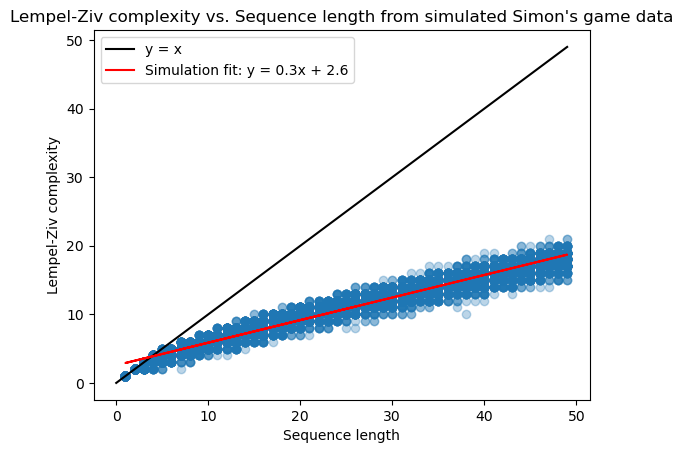

Simulation data expected value: 25.15488



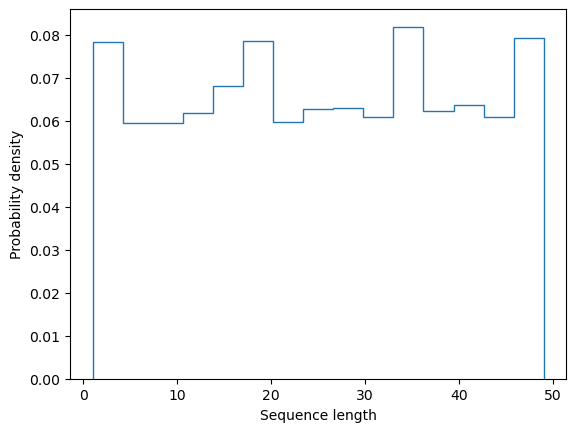

In [13]:
def generate_random_sequence(max_seq_len=100):
    sequence = "".join(
        np.random.choice(["B", "G", "R", "Y"], size=np.random.randint(1, max_seq_len))
    )
    return sequence


# Generate sequences and compute LZ complexity scores
n = 10000
max_seq_len = 50
sequences, lengths, scores = [], [], []
for _ in range(n):
    sequence = generate_random_sequence(max_seq_len=max_seq_len)
    sequences.append(sequence)
    length = len(sequence)
    lengths.append(length)
    score = round(lempel_ziv_complexity(sequence), 3)
    scores.append(score)

# Plot the results of the simulation
plt.figure()
plt.scatter(lengths, scores, alpha=0.3)
# Plot y=x line
max_len = max(lengths)
plt.plot([0, max_len], [0, max_len], label="y = x", color="k")
# Calculate best fit line parameters
a, b = np.polyfit(lengths, scores, 1)
# Round the slope and intercept to 1 decimal place
a_rounded = round(a, 1)
b_rounded = round(b, 1)
# Create label string for the best fit line
best_fit_label = f"Simulation fit: y = {a_rounded}x + {b_rounded}"
# Plot best fit line with the equation in the label
plt.plot(lengths, a * np.array(lengths) + b, label=best_fit_label, color="red")
plt.xlabel("Sequence length")
plt.ylabel("Lempel-Ziv complexity")
plt.title("Lempel-Ziv complexity vs. Sequence length from simulated Simon's game data")
# Set legend to only show the y=x line and best fit line
plt.legend()
plt.show()

plt.figure()
counts, bins = np.histogram(lengths, bins=15)
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
probs = counts / sum(counts)
plt.stairs(probs, bins)
plt.xlabel("Sequence length")
plt.ylabel("Probability density")
expectation = sum(probs * bin_centers)
print(f"Simulation data expected value: {expectation}\n")
plt.show()

### Collect data from all game logs and plot the LZ-complexity versus sequence length.

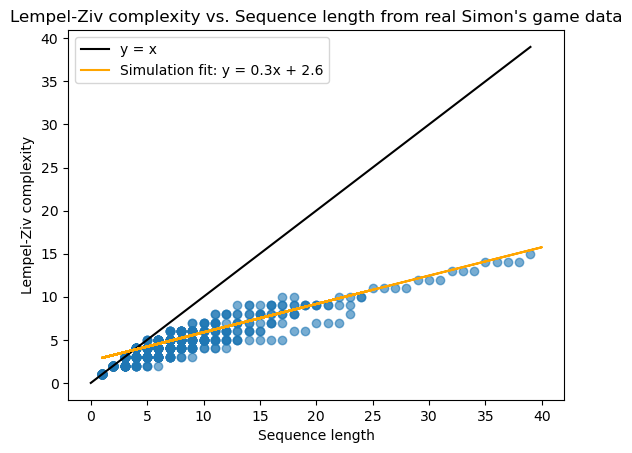

Human data expected value: 6.5647569444444445



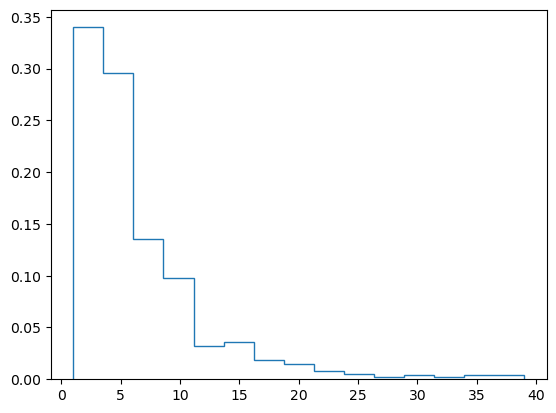

In [14]:
root_path = "."  # all the games are within subdirectories
all_sessions_data = parse_simons_game_logs(root_path)

sequences, lengths, scores = [], [], []
for session in all_sessions_data:
    session_data = all_sessions_data[session]
    for game in session_data:
        sequence = session_data[game]["longest_sequence"]
        sequences.append(sequence)
        length = len(sequence)
        lengths.append(length)
        score = round(lempel_ziv_complexity(sequence), 3)
        scores.append(score)

# Because of the way the Simons game is played, actually all subsequences of the longest sequence are also valid sequences.
# This means that the Lempel-Ziv complexity of the longest sequence is actually the maximum possible complexity for that game.

_sequences_, _lengths_, _scores_ = [], [], []
for seq in sequences:
    for _ in range(1, len(seq)):
        s = seq[:_]
        _sequences_.append(s)
        l = len(s)
        _lengths_.append(l)
        r = round(lempel_ziv_complexity(s), 3)
        _scores_.append(r)

# Plot the human player results
plt.figure()
plt.scatter(_lengths_, _scores_, alpha=0.6)
# Plot y=x line
_max_len_ = max(_lengths_)
plt.plot([0, _max_len_], [0, _max_len_], label="y = x", color="k")
# Calculate best fit line parameters
_a_, _b_ = np.polyfit(_lengths_, _scores_, 1)
# Round the slope and intercept to 1 decimal place
_a_rounded_ = round(_a_, 1)
_b_rounded_ = round(_b_, 1)
# Create label string for the best fit line
# _best_fit_label_ = f"Real data fit: y = {_a_rounded_}x + {_b_rounded_}"
# # Plot best fit line (for real and simulated data) with the equation in the label
# plt.plot(
#     np.array(_lengths_), _a_ * np.array(_lengths_) + _b_, label=_best_fit_label_, color="red"
# )
plt.plot(
    np.array(lengths), a * np.array(lengths) + b, label=best_fit_label, color="orange"
)
plt.xlabel("Sequence length")
plt.ylabel("Lempel-Ziv complexity")
plt.title("Lempel-Ziv complexity vs. Sequence length from real Simon's game data")
# Set legend to only show the y=x line and best fit line
plt.legend()
plt.show()

plt.figure()
_counts_, _bins_ = np.histogram(_lengths_, bins=15)
_bin_centers_ = 0.5 * np.diff(_bins_) + _bins_[:-1]
_probs_ = _counts_ / sum(_counts_)
plt.stairs(_probs_, _bins_)
_expectation_ = sum(_probs_ * _bin_centers_)
print(f"Human data expected value: {_expectation_}\n")
plt.show()

### Set up a statistical test to see if long sequences from human players is of low-complexity.

In [15]:
# Calculate residuals for human data referenced to the simulated data regression line
# but only for sequences longer than the expected value from the real game data
_fillter_ = np.array(_lengths_) > _expectation_
x_human = np.array(_lengths_)[_fillter_]
y_human = np.array(_scores_)[_fillter_]
residuals = y_human - (a * x_human + b)

fillter = np.array(lengths) > _expectation_
x_simul = np.array(lengths)[fillter]
y_simul = np.array(scores)[fillter]
residuals = y_simul - (a * x_simul + b)

# Count the number of points above and below the regression line
above = np.sum(residuals > 0)
below = np.sum(residuals < 0)

# Perform the sign test
test_result = binomtest(above, n=above + below, p=0.5, alternative="two-sided")
p_value = test_result.pvalue

# Output the results
print("Number of points above the line:", above)
print("Number of points below the line:", below)
print("P-value from the sign test:", p_value)

# Conclusion
if p_value < 0.05:
    print(
        "Reject the null hypothesis: Significant difference in the number of points above vs. below the line."
    )
else:
    print(
        "Fail to reject the null hypothesis: No significant difference in the number of points above vs. below the line."
    )

Number of points above the line: 39
Number of points below the line: 29
P-value from the sign test: 0.2749903961710005
Fail to reject the null hypothesis: No significant difference in the number of points above vs. below the line.


### Determine and plot the distribution of sequence lengths at each LZ-complexity 

This analysis illustrates that LZ-complexity -- a metric or quantity originally defined algorithmically -- can also be viewed as a statistical object (i.e a random variable) which depends on the alphabet size and the sequence length.

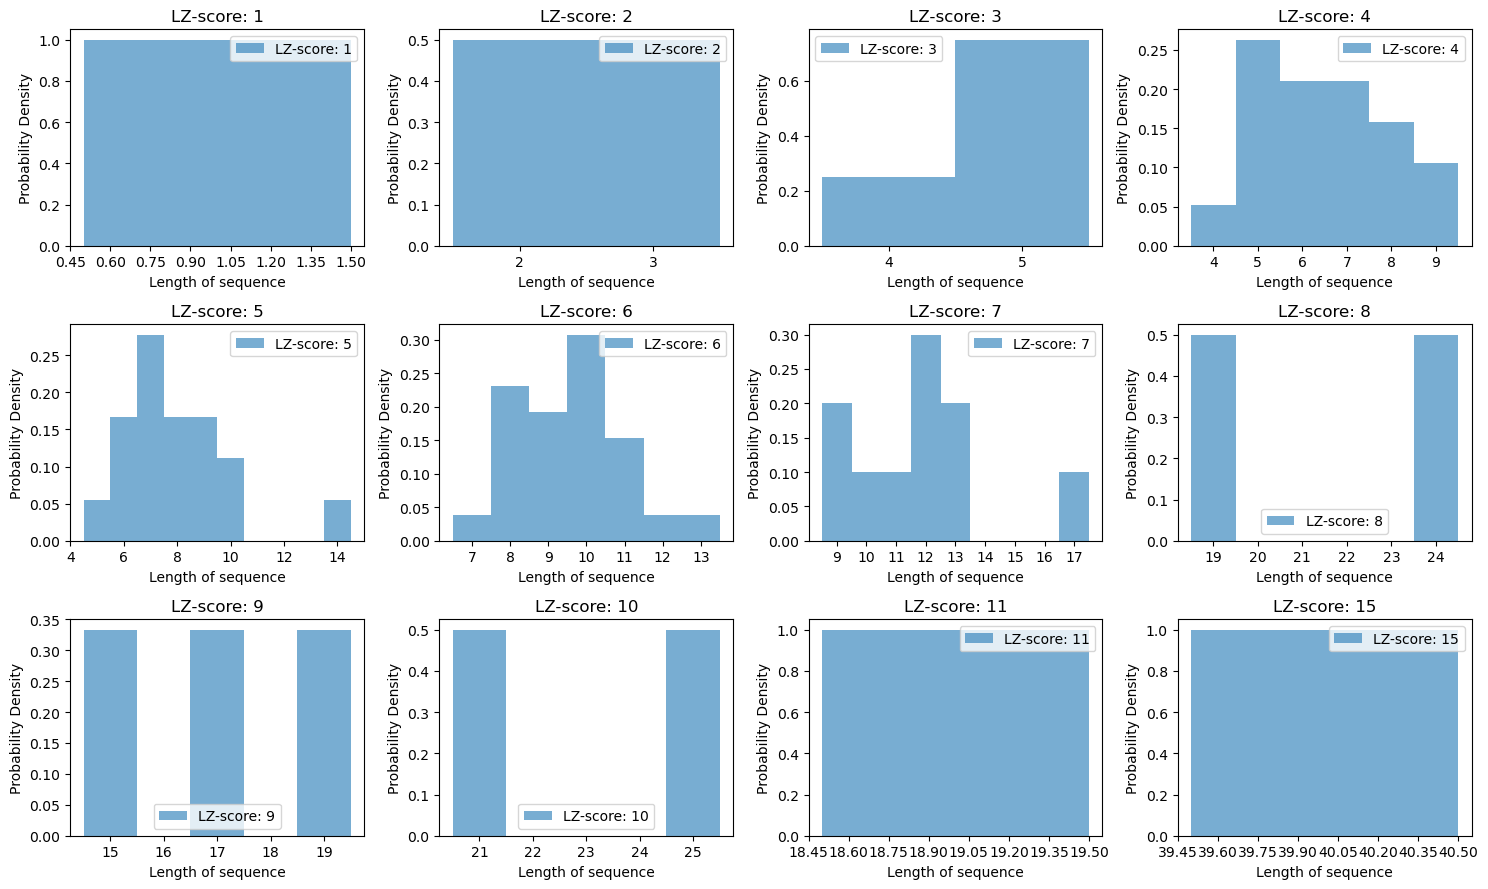

In [16]:
# Mapping from sequences to LZ scores
score_to_sequences = defaultdict(list)
for score, sequence in zip(scores, sequences):
    score_to_sequences[score].append(sequence)

# Calculate the number of rows/columns for the subplots
unique_scores = sorted(np.unique(scores))
n_unique_scores = len(unique_scores)
n_cols = 4  # You can define how many columns you want
n_rows = (
    n_unique_scores + n_cols - 1
) // n_cols  # This ensures that we have enough rows

# Create subplots
fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(15, n_rows * 3)
)  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Plot a histogram for each LZ-score on its own subplot
for idx, score in enumerate(unique_scores):
    lens = [len(seq) for seq in score_to_sequences[score]]
    axs[idx].hist(
        lens,
        bins=np.arange(min(lens) - 0.5, max(lens) + 1.5),
        alpha=0.6,
        label=f"LZ-score: {score}",
        density=True,
    )
    axs[idx].xaxis.set_major_locator(
        MaxNLocator(integer=True)
    )  # Set x-axis to show only integer ticks
    axs[idx].set_xlabel("Length of sequence")
    axs[idx].set_ylabel("Probability Density")
    axs[idx].set_title(f"LZ-score: {score}")
    axs[idx].legend()

# Hide any extra subplots that aren't needed
for ax in axs[n_unique_scores:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Determine and plot the distribution of LZ-complexity at each sequence length

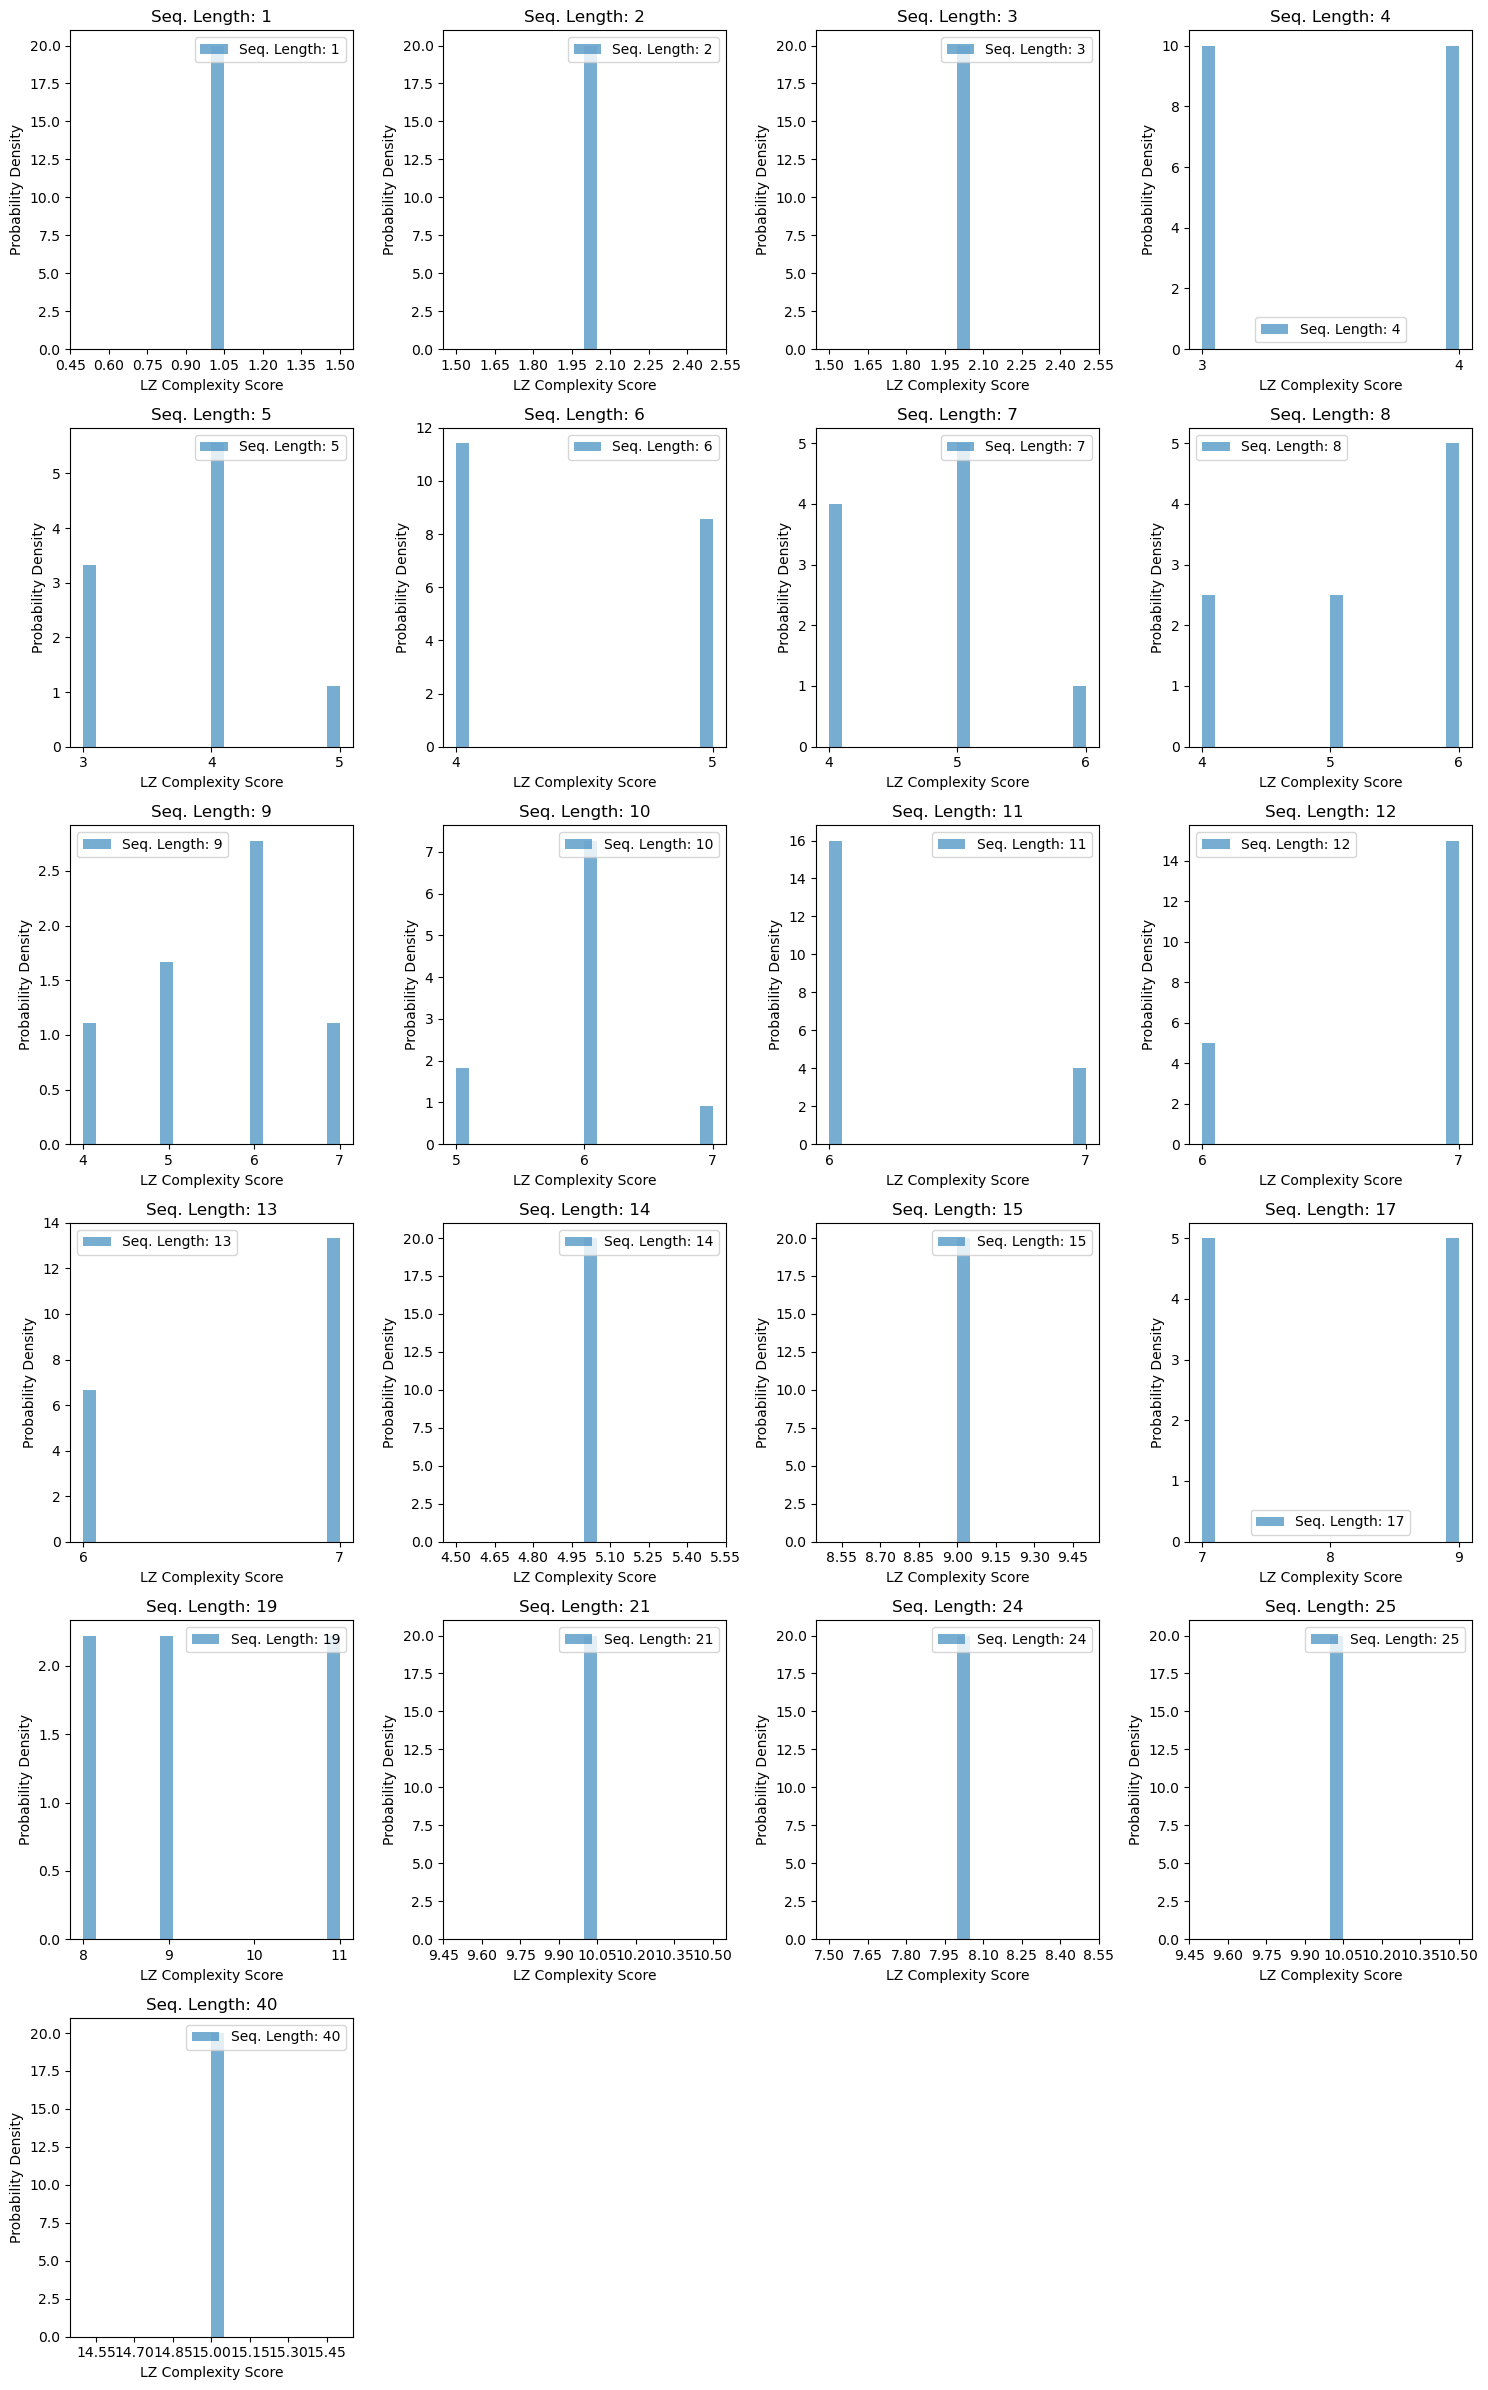

In [17]:
# Mapping seqeunce lengths to LZ scores
length_to_scores = defaultdict(list)
for length, score in zip(lengths, scores):
    length_to_scores[length].append(score)

# Now let's plot the distribution of LZ-scores for each sequence length
unique_lengths = sorted(np.unique(lengths))
n_unique_lengths = len(unique_lengths)
n_cols = 4  # You can define how many columns you want
n_rows = (
    n_unique_lengths + n_cols - 1
) // n_cols  # This ensures that we have enough rows

# Create subplots
fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(15, n_rows * 4)
)  # Adjust the size as needed
axs = axs.flatten()  # Flatten the array of axes for easy iteration

# Plot a histogram for each sequence length on its own subplot
for idx, length in enumerate(unique_lengths):
    axs[idx].hist(
        length_to_scores[length],
        bins=20,
        alpha=0.6,
        label=f"Seq. Length: {length}",
        density=True,
    )
    axs[idx].xaxis.set_major_locator(
        MaxNLocator(integer=True)
    )  # Set x-axis to show only integer ticks
    axs[idx].set_xlabel("LZ Complexity Score")
    axs[idx].set_ylabel("Probability Density")
    axs[idx].set_title(f"Seq. Length: {length}")
    axs[idx].legend()

# Hide any extra subplots that aren't needed
for ax in axs[n_unique_lengths:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Quilee's Hypotheses (on the effect of chunking on memory retrieval / performance)

1. When people achieve long sequences in the Simons game, the LZ-complexity of those sequences is lower than the expected value given that sequence length.

2. When people achieve short sequences in the Simons game, the LZ-complexity of those sequences is higher than the expected value given that sequence length.

**Prediction:** The human data could be viewed as a biased sample from the full distribution of the simulated data (i.i.d random sequences). 
We expect that most of the human data would fall below the best-fit line from regression on the simulated data. Our hypotheses suggest that we should see higher LZ-complexities at shorter sequence lengths (caveman translation: less chunkable sequence make game harder); and lower LZ-complexities at longer sequences (caveman translation: more chunkable sequence make game easier).

**Preliminary Results**: Preliminary results suggest that we fail to reject only the first hypothesis.

**Thoughts:** We saw earlier that LZ-complexity is linearly proportional to the length of the sequence. The linear relationship means people with higher memory capacity can score higher in the Simons game. This is almost like stating the obvious. But what these hypotheses claim is that, controlling for individual memory capacity (i.e. asked to remember a sequence of some fixed length), individuals remember low LZ-complexity sequences better than they do high LZ-complexity ones. In essence, people remember more "chunkable" sequences better than less "chunkable" ones. This may also seem like stating something obvious. Of course, this statement relies on us _defining_ "chunkability" as inverse LZ-complexity.

**Conclusion (?):** A person's performance on the Simon's game (or more generally whatever ethological characteristic that we claim the Simon's game reflects/captures/is a proxy of/etc.) is a function of:

1. the person's own baseline memory capacity (i.e. how many symbols/characters can they remember sequentially);
    - This requires us to define "capacity" as the maximum number of characters a person can remember, but independent from their chunking ability. A way to measure this without the confound of chunking is using random sequences of alphanumeric characters with no repeats e.g. `4c1j5b2p0cv4w1x8rx2y39umgw5q85s7`.
2. the LZ-complexity of the particular sequence. 
    - Since we define LZ-complexity as inversely proportional "chunkability", this says that a person's ability to chunk a sequence helps improve memory at any given  level of capacity. 

**Usefulness (?):** Equipped with the above distinction between memory capacity and sequence complexity/chunkability, we may be able to quantify individual chunking skill by the maximum LZ-complexity a player can reproduce for a prespecified sequence length.

**Discussion (?):** Humans not only have to identify/form a collection of what the unique/reusable patterns (i.e. "chunks") are, but _where_/_when_ to place them in order to reproduce a sequence. The use of LZ-complexity as our metric for chunking somewhat captures this confound because it is computed as a stream.

#### Jack's hypotheses (on neural implementation of chunking)
Chunking of repeat substrings is implemented neurally as a population of cells that modulates firing rate as a function of repeats. Two possible implementions are:
1. **(?)** _what was it called ..._
    - 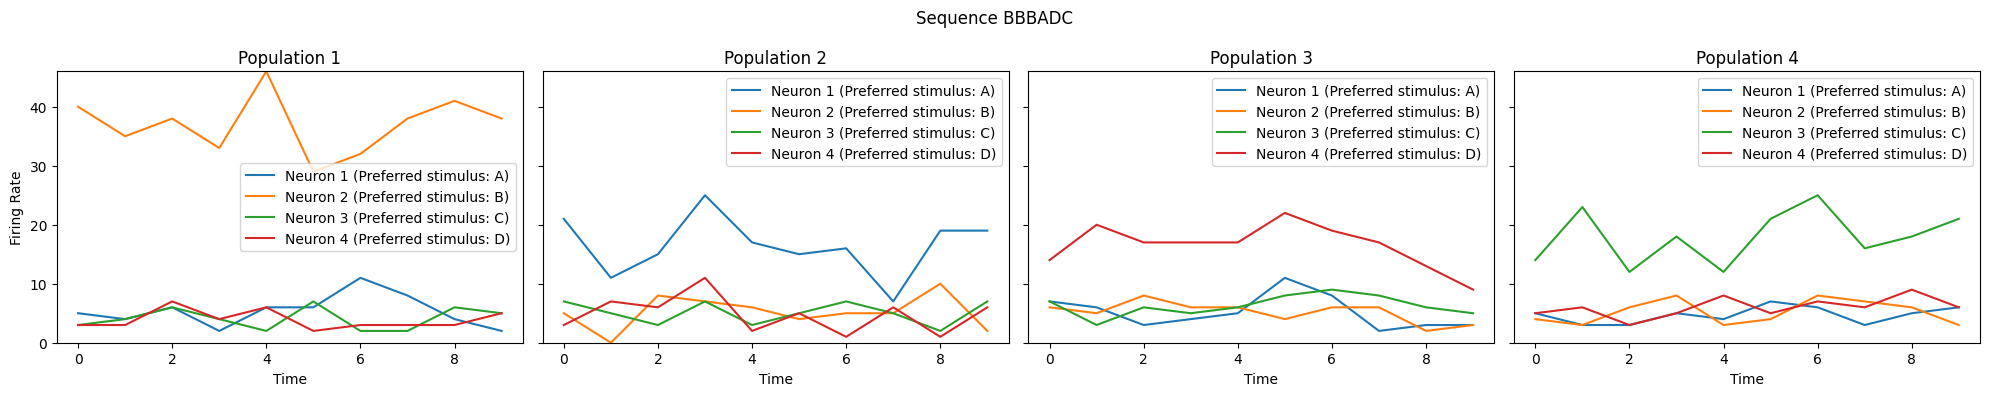
    
2. **Oscillations**
    - 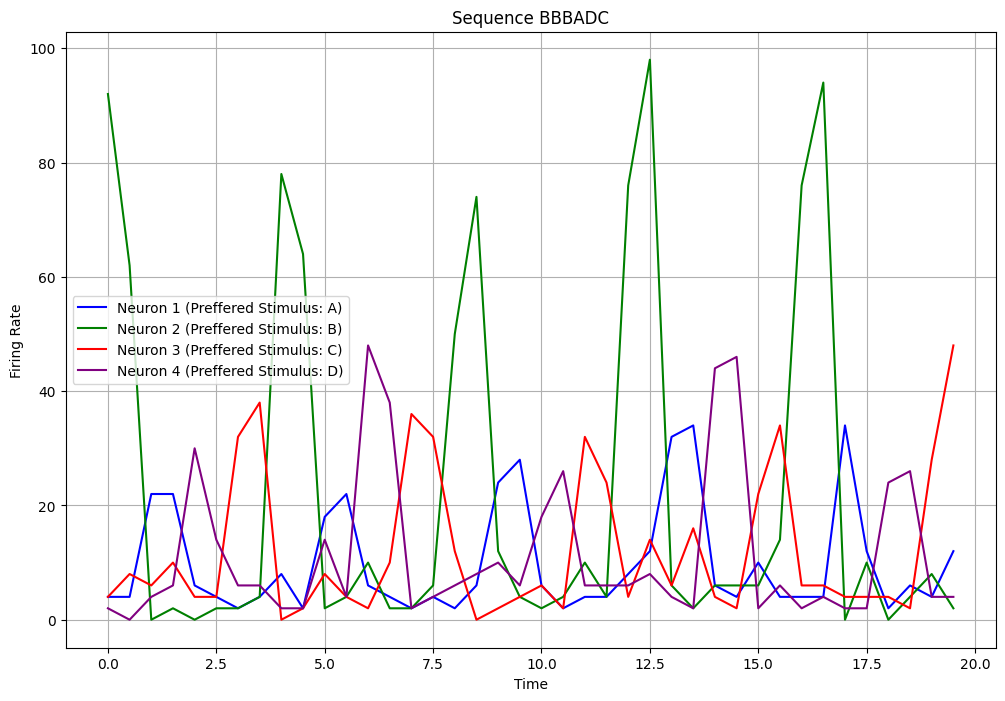

